# Portfolio Optimization and Parameter Uncertainty
This example is the accompanied code for the Portfolio Optimization and Parameter Uncertainty article available at: https://ssrn.com/abstract=4709317.

The example illustrates the effect of parameter uncertainty in the means, variances, and correlations for mean-variance portfolio optimization. It also tests the out-of-sample performance of the new Exposure Stacking method and compares it to the traditional resampling method.

In [1]:
import numpy as np
import pandas as pd
import fortitudo.tech as ft
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from cvxopt import matrix, solvers
from copy import copy

In [2]:
# Load instrument info
instrument_names, means, covariance_matrix = ft.load_parameters()
vols = np.sqrt(np.diag(covariance_matrix))
correlation_matrix = np.diag(vols**-1) @ covariance_matrix @ np.diag(vols**-1)

In [3]:
# Specify base long-only constraints
I = len(instrument_names)
G = -np.eye(I)
h = np.zeros(I)
mv_opt = ft.MeanVariance(means, covariance_matrix, G, h)

In [4]:
# Parameter uncertainty specification
B = 1000  # Number of efficient frontiers
P = 9  # Number of portfolios used to span the efficient frontiers
N = 100  # Sample size for parameter estimation
np.random.seed(3)  # To avoid numerical instability
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [5]:
# Base frontier with no parameter uncertainty
frontier = mv_opt.efficient_frontier(P)
results = np.full((P, 2), np.nan)
results[:, 0] = means @ frontier
for p in range(P):
    results[p, 1] = frontier[:, p] @ covariance_matrix @ frontier[:, p]

# Analysis of parameter importance
We illustrate the effect on mean-variance efficient frontiers from purposefully introducing uncertainty in the mean, vol, and correlation.

In [6]:
# Mean uncertainty
frontier_mean = np.full((I, P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)
for b in range(B):
    means_run = np.mean(return_sim[:, b, :], axis=0)
    mv_opt._expected_return_row = -matrix(means_run).T
    frontier_mean[:, :, b] = mv_opt.efficient_frontier(P)
    mean_results[:, 0, b] = means @ frontier_mean[:, :, b]
    for p in range(P):
        mean_results[p, 1, b] = frontier_mean[:, p, b] @ covariance_matrix @ frontier_mean[:, p, b]
mv_opt._expected_return_row = -matrix(means).T  # Reset means

In [7]:
# Vol uncertainty
frontier_vol = np.full((I, P, B), np.nan)
vol_results = np.full((P, 2, B), np.nan)
for b in range(B):
    vols_run = np.diag(np.std(return_sim[:, b, :], axis=0))
    cov_matrix_run = vols_run @ correlation_matrix @ vols_run
    mv_opt._P = matrix(1000 * cov_matrix_run)
    frontier_vol[:, :, b] = mv_opt.efficient_frontier(P)
    vol_results[:, 0, b] = means @ frontier_vol[:, :, b]
    for p in range(P):
        vol_results[p, 1, b] = frontier_vol[:, p, b] @ covariance_matrix @ frontier_vol[:, p, b]

In [8]:
# Correlation uncertainty
frontier_cor = np.full((I, P, B), np.nan)
cor_results = np.full((P, 2, B), np.nan)
for b in range(B):
    cor_matrix_run = ft.correlation_matrix(return_sim[:, b, :]).values
    cov_matrix_run = np.diag(vols) @ cor_matrix_run @ np.diag(vols)
    mv_opt._P = matrix(1000 * cov_matrix_run)
    frontier_cor[:, :, b] = mv_opt.efficient_frontier(P)
    cor_results[:, 0, b] = means @ frontier_cor[:, :, b]
    for p in range(P):
        cor_results[p, 1, b] = frontier_cor[:, p, b] @ covariance_matrix @ frontier_cor[:, p, b]

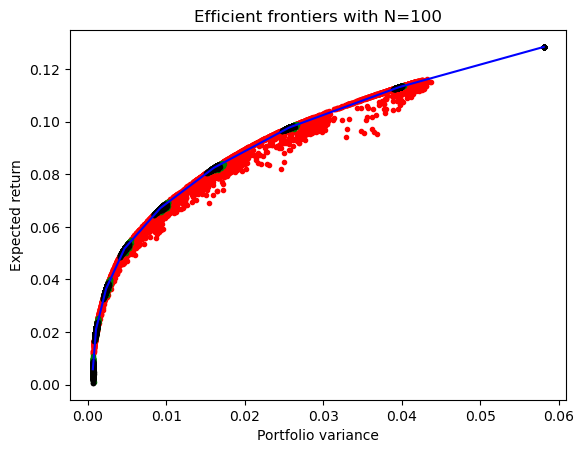

In [9]:
plt.plot(mean_results[:, 1, :], mean_results[:, 0, :], 'r.')
plt.plot(vol_results[:, 1, :], vol_results[:, 0, :], 'g.')
plt.plot(cor_results[:, 1, :], cor_results[:, 0, :], 'k.')
plt.plot(results[:, 1], results[:, 0], 'b-')
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio variance')
plt.show()

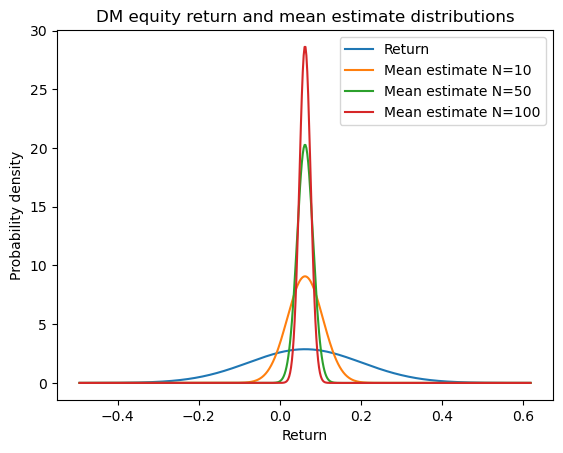

In [10]:
# Visualize mean uncertainty for some different sample sizes
x_min = means[4] - 4 * vols[4]
x_max = means[4] + 4 * vols[4]
x = np.linspace(x_min, x_max, 500)
plt.plot(x, stats.norm.pdf(x, means[4], vols[4]))
plt.plot(x, stats.norm.pdf(x, means[4], vols[4] / np.sqrt(10)))
plt.plot(x, stats.norm.pdf(x, means[4], vols[4] / np.sqrt(50)))
plt.plot(x, stats.norm.pdf(x, means[4], vols[4] / np.sqrt(100)))
plt.legend(['Return', 'Mean estimate N=10', 'Mean estimate N=50', 'Mean estimate N=100'])
plt.title('DM equity return and mean estimate distributions')
plt.ylabel('Probability density')
plt.xlabel('Return')
plt.show()

# Sample convergence (traditional resampling)
We use the traditional resampling approach on the middle portfolio to investigate how many samples are needed before the resulting exposures start to converge.

In [11]:
pf_index = 4

In [12]:
# Efficient frontier without resampling
np.round(frontier[:, pf_index] * 100, 1)

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , 20.4, 40.5, 11.1, 28. ])

In [13]:
exposure_re_vals = np.full((4, B), np.nan)
for b in range(B):
    re_pf = np.mean(frontier_mean[:, pf_index, 0:b+1], axis=1)
    exposure_re_vals[:, b] = re_pf[-4:]

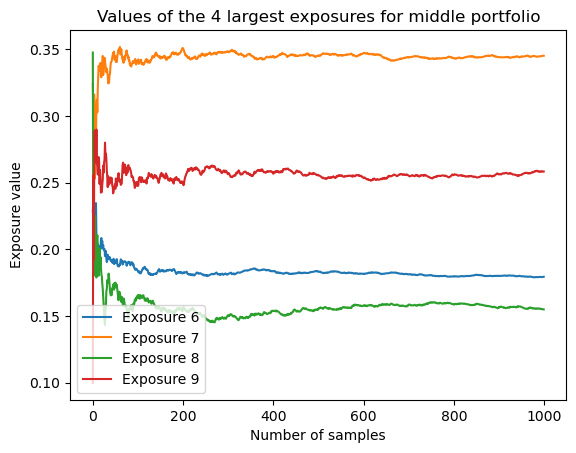

In [14]:
plt.plot(exposure_re_vals.T)
plt.legend(['Exposure 6', 'Exposure 7', 'Exposure 8', 'Exposure 9'])
plt.xlabel('Number of samples')
plt.ylabel('Exposure value')
plt.title('Values of the 4 largest exposures for middle portfolio')
plt.show()

# Exposure stacking
We implement the new Exposure Stacking method and test it against out-of-sample means and variances. As can be seen, Exposure Stacking has potential for better risk-adjusted returns than the traditional resampling method.

In [15]:
def exposure_stacking(L, frontier, num_samples):
    """Computes the L-fold Exposure Stacking.

    Partitions the first num_samples samples from the frontier into L sets 
    of equal size and computes the L-fold Exposure Stacking.

    Args:
        L: Number of partition sets.
        frontier: Resampled exposures frontier with shape (I, P, B).
        num_samples: Number of samples to include.

    Returns:
        Exposure Stacking portfolio.    
    """
    partition_size = num_samples // L  # If L does not divide num_bootstraps "remainder data" is not used.
    M = frontier[:, pf_index, :num_samples].T
    P = np.zeros((num_samples, num_samples))
    q = np.zeros((num_samples, 1))
    for l in range(L):
        K_l = np.arange(l * partition_size, (l + 1) * partition_size)
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(frontier[:, pf_index, K_l], axis=1)
        q = q + (M_l @ sum_exposures_K_l)[:, np.newaxis]
    P = matrix(2 * partition_size * P)
    q = matrix(-2 * q)
    # Weights must sum to one
    A = matrix(np.ones((1, num_samples)))
    b = matrix(np.array([[1.]]))
    # Weights must be nonnegative
    G = matrix(-np.identity(num_samples))
    h = matrix(np.zeros((num_samples, 1)))
    sol = solvers.qp(P, q, G, h, A, b)
    w = sol['x']
    exposure = np.squeeze(M.T @ w)
    return exposure


In [16]:
num_samples = B
exposure_2 = exposure_stacking(2, frontier_mean, num_samples)
exposure_5 = exposure_stacking(5, frontier_mean, num_samples)
exposure_B = exposure_stacking(B, frontier_mean, num_samples)

In [17]:
exposures_for_display = np.round(np.vstack((re_pf, exposure_2, exposure_5, exposure_B, frontier[:, pf_index])) * 100, 2).T
pd.DataFrame(exposures_for_display, columns=['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])

,Resampled,2-fold,5-fold,B-fold,Frontier portfolio
0,0.13,0.00,0.00,0.11,0.00
1,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00
3,5.48,0.00,2.03,5.46,0.00
4,0.50,0.00,0.00,0.50,0.00
5,0.08,0.00,0.00,0.10,0.00
6,17.94,13.98,17.61,17.95,20.41
7,34.53,47.14,38.33,34.53,40.49
8,15.50,9.09,14.55,15.50,11.06
9,25.84,29.78,27.48,25.85,28.04


In [18]:
# Out-of-sample simulations
return_sim_oos = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [19]:
def risk_return(pf):
    """Computes the out of sample risk and return of the portfolio.

    Args:
        pf: Portfolio to measure risk and return against.

    Returns:
        Array of shape (2, B) with risk and return for each of the B simulations.
    """
    risk_return = np.full((2, B), np.nan)
    for b in range(B):
        means_run = np.mean(return_sim_oos[:, b, :], axis=0)
        cov_run = np.cov(return_sim_oos[:, b, :], rowvar=False)
        risk_return[0, b] = pf @ cov_run @ pf
        risk_return[1, b] = means_run @ pf
    return risk_return

In [20]:
re_rr = risk_return(re_pf)
re_rar = re_rr[1, :] / re_rr[0, :]
frontier_rr = risk_return(frontier[:, pf_index])
frontier_rar = frontier_rr[1, :] / frontier_rr[0, :]
es_2_rr = risk_return(exposure_2)
es_2_rar = es_2_rr[1, :] / es_2_rr[0, :]
es_5_rr = risk_return(exposure_5)
es_5_rar = es_5_rr[1, :] / es_5_rr[0, :]
es_B_rr = risk_return(exposure_B)
es_B_rar = es_B_rr[1, :] / es_B_rr[0, :]

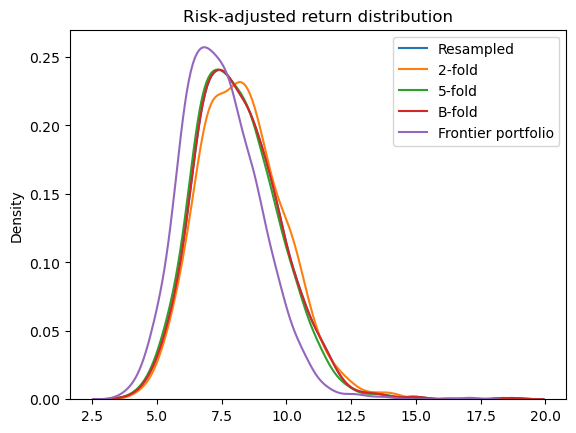

In [21]:
sns.kdeplot(x=re_rar)
sns.kdeplot(x=es_2_rar)
sns.kdeplot(x=es_5_rar)
sns.kdeplot(x=es_B_rar)
sns.kdeplot(x=frontier_rar)
plt.title('Risk-adjusted return distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()

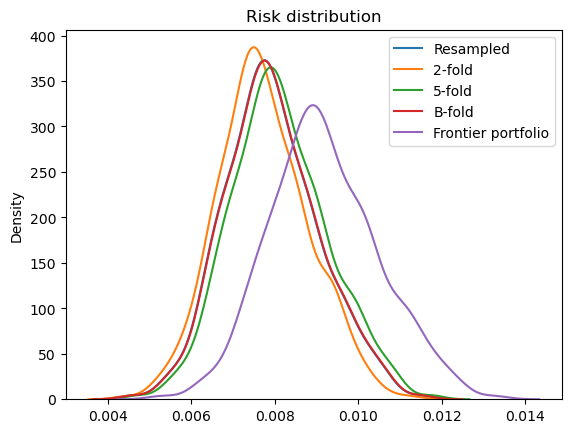

In [22]:
sns.kdeplot(x=re_rr[0, :])
sns.kdeplot(x=es_2_rr[0, :])
sns.kdeplot(x=es_5_rr[0, :])
sns.kdeplot(x=es_B_rr[0, :])
sns.kdeplot(x=frontier_rr[0, :])
plt.title('Risk distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()

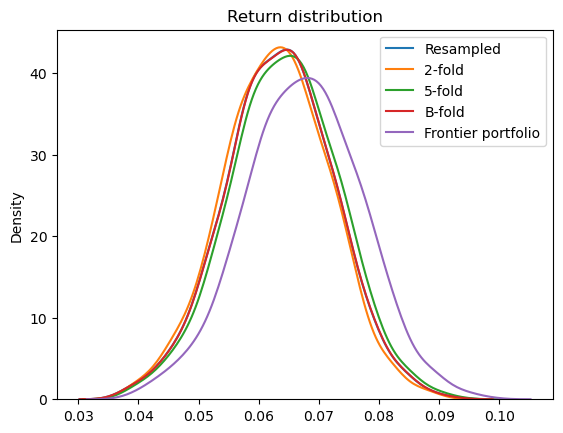

In [23]:
sns.kdeplot(x=re_rr[1, :])
sns.kdeplot(x=es_2_rr[1, :])
sns.kdeplot(x=es_5_rr[1, :])
sns.kdeplot(x=es_B_rr[1, :])
sns.kdeplot(x=frontier_rr[1, :])
plt.title('Return distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()

# Exposure stacking with fewer samples

In [24]:
num_samples = 100
exposure_2_100 = exposure_stacking(2, frontier_mean, num_samples)
exposure_5_100 = exposure_stacking(5, frontier_mean, num_samples)
exposure_B_100 = exposure_stacking(B, frontier_mean, num_samples)
re_pf_100 = np.mean(frontier_mean[:, pf_index, :num_samples], axis=1)

es_2_rr_100 = risk_return(exposure_2_100)
es_2_rar_100 = es_2_rr_100[1, :] / es_2_rr_100[0, :]
es_5_rr_100 = risk_return(exposure_5_100)
es_5_rar_100 = es_5_rr_100[1, :] / es_5_rr_100[0, :]
es_B_rr_100 = risk_return(exposure_B_100)
es_B_rar_100 = es_B_rr_100[1, :] / es_B_rr_100[0, :]
re_rr_100 = risk_return(re_pf_100)
re_rar_100 = re_rr_100[1, :] / re_rr_100[0, :]

In [25]:
num_samples = 500
exposure_2_500 = exposure_stacking(2, frontier_mean, num_samples)
exposure_5_500 = exposure_stacking(5, frontier_mean, num_samples)
exposure_B_500 = exposure_stacking(B, frontier_mean, num_samples)
re_pf_500 = np.mean(frontier_mean[:, pf_index, :num_samples], axis=1)

es_2_rr_500 = risk_return(exposure_2_500)
es_2_rar_500 = es_2_rr_500[1, :] / es_2_rr_500[0, :]
es_5_rr_500 = risk_return(exposure_5_500)
es_5_rar_500 = es_5_rr_500[1, :] / es_5_rr_500[0, :]
es_B_rr_500 = risk_return(exposure_B_500)
es_B_rar_500 = es_B_rr_500[1, :] / es_B_rr_500[0, :]
re_rr_500 = risk_return(re_pf_500)
re_rar_500 = re_rr_500[1, :] / re_rr_500[0, :]

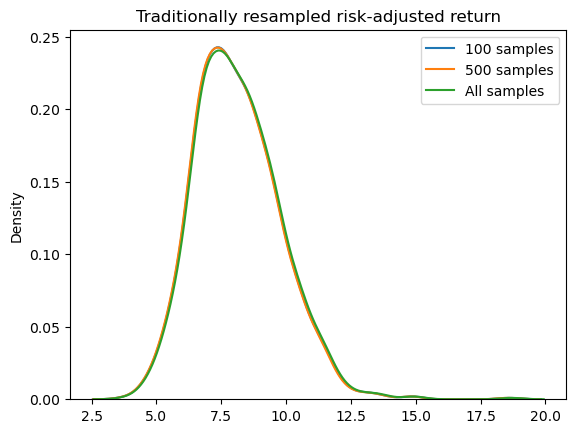

In [26]:
sns.kdeplot(re_rar_100)
sns.kdeplot(re_rar_500)
sns.kdeplot(re_rar)
plt.title('Traditionally resampled risk-adjusted return')
plt.legend(['100 samples', '500 samples', 'All samples'])
plt.show()

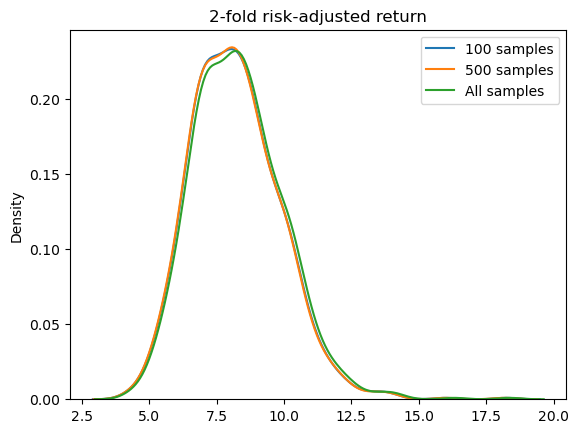

In [27]:
sns.kdeplot(es_2_rar_100)
sns.kdeplot(es_2_rar_500)
sns.kdeplot(es_2_rar)
plt.title('2-fold risk-adjusted return')
plt.legend(['100 samples', '500 samples', 'All samples'])
plt.show()

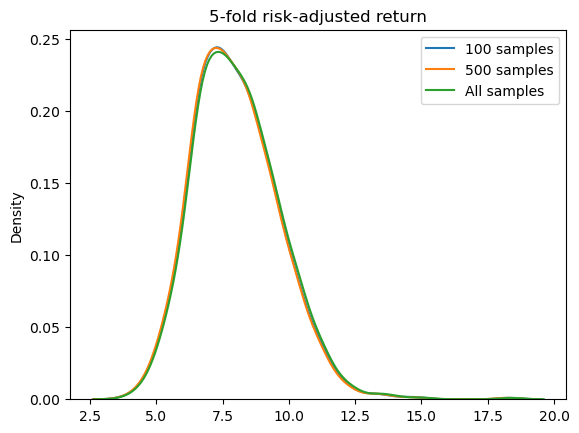

In [28]:
sns.kdeplot(es_5_rar_100)
sns.kdeplot(es_5_rar_500)
sns.kdeplot(es_5_rar)
plt.title('5-fold risk-adjusted return')
plt.legend(['100 samples', '500 samples', 'All samples'])
plt.show()

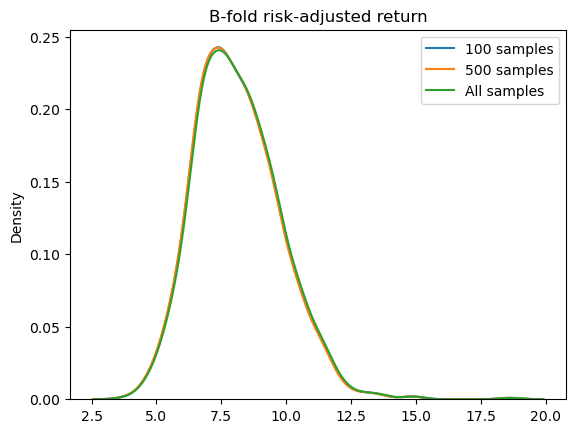

In [29]:
sns.kdeplot(es_B_rar_100)
sns.kdeplot(es_B_rar_500)
sns.kdeplot(es_B_rar)
plt.title('B-fold risk-adjusted return')
plt.legend(['100 samples', '500 samples', 'All samples'])
plt.show()

# License

In [30]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2024 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.